### Text classification using Tf-Idf

In [7]:
import json
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import wordnet
from nltk import pos_tag, word_tokenize
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn import metrics

import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

from datetime import datetime
from tensorflow.keras import Model, Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.layers import Activation, Dense, Embedding, GlobalAveragePooling1D, Dropout, MaxPooling1D, Conv1D, LSTM
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Flatten

#### Reading a subset from Yelp Dataset

In [8]:
df_b = pd.read_json('yelp_academic_dataset_review.json', lines=True, chunksize=300000)

In [9]:
data=[]
for c in df_b:
    data=c
    break
    

In [10]:
# Shape of the selected data 
data.shape

(300000, 9)

In [11]:
# Last 5 rows of the data
data.tail()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
299995,0-nk09u6gk4oonzcW4LgMQ,zJfJC--nT-xKLTzdyvroyw,aY-lZvoTHAFl9k6dcfcAxQ,5,0,0,0,Very delicious food and amazing service! I com...,2015-08-12 01:49:19
299996,gJwywVNsIfFlCKiBQj93uw,8nCmV4RMwf4GpaN-A_2Tfw,Khs3iUmkHce7xpAyOo5kRg,3,1,0,0,Sardella's is my favorite pizza chain in the v...,2012-08-23 16:54:00
299997,_0Q9Qg3CZJfuLTtH5KkxbA,nKdhohT1D6doq_v0ReBvzQ,m97jaBYRscg-hqDjMVIIWg,2,0,0,0,The Hostess was the worst. Not very inviting i...,2015-08-24 21:33:18
299998,uc_2Q_UvC0r0AZnERb1k4w,hHuDkGLAOTlR-lLCROotbA,Xs2iTWxbczvfEapAFH3cyw,5,0,1,0,Moved to a new neighborhood = hunt for a new b...,2015-10-23 02:06:21
299999,Q_2ppaCk3go14WNSXUB1Rg,usfq6zK3yG1IA0V5k6XHyQ,mP5qGYKMpy5WWe5BVN5dig,5,1,0,0,This is the best mechanic experience I have ha...,2017-01-07 00:34:54


In [12]:
# Review comment of a random record

data.iloc[3456,7]


"The food has always been good and the service just keeps getting better.  They recently remodeled the building, so it's very modern/clean looking.  They always give you a heaping mound of each dish, so you never feel you're not getting your money's worth.  There's an extra $0.50 or $1.00 for some of the more premium items (shrimp, added bacon, etc) but it's always worth it.  I wouldn't want to eat there every day, but I'm always happy when I get the chance."

Count of different ratings:
  stars
1     41433
2     24493
3     33588
4     68426
5    132060
dtype: int64


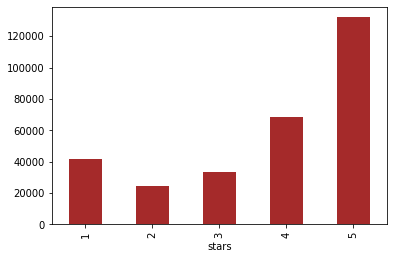

In [13]:

r=data.groupby('stars').size()
print("Count of different ratings:\n ",r)
r.plot.bar(color='brown');

# Data is unbalanced with less records with ratings 2 and 3 and maximum of rating 5

In [14]:
# Balancing the data, considering ratings would be clubbed later on

d1=data[data.stars==1].sample(16794, replace=False)
d2=data[data.stars==2].sample(16794, replace=False)
d3=data[data.stars==3].sample(33588, replace=False)
d4=data[data.stars==4].sample(16794, replace=False)
d5=data[data.stars==5].sample(16794, replace=False)

data=pd.concat([d1,d2,d3,d4,d5])

data.shape

(100764, 9)

In [15]:
pd.options.display.float_format = '{:,.2f}'.format

In [16]:
data.describe()

# Data is categorical, so not much useful info gained apart from the range

,stars,useful,funny,cool
count,"100,764.00","100,764.00","100,764.00","100,764.00"
mean,3.00,1.18,0.43,0.42
std,1.29,2.34,1.38,1.30
min,1.00,0.00,0.00,0.00
25%,2.00,0.00,0.00,0.00
50%,3.00,0.00,0.00,0.00
75%,4.00,1.00,0.00,0.00
max,5.00,73.00,66.00,54.00


#### Pre-processing the Text

In [17]:
# Function to remove the word contractions, like convert isn't to is not
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"ain\'t", "am not", phrase) 
    
    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

In [19]:
# Function to lemmatize - converting a word to its root
def lemmatise(phrase):
    arr=[]
    t=pos_tag(word_tokenize(phrase))
    for a in t:
        postag=get_wordnet_pos(a[1])
        if not postag:
            continue
        p=nltk.stem.WordNetLemmatizer().lemmatize(a[0],pos=postag)
        arr.append(p)
    return arr

In [20]:
# Function to remove stopwords excluding the negations like not, no 

def rem_stopwords(phrase):
    sw=stopwords.words('english')
    sw.remove('no')
    sw.remove('not')
    sw.remove('nor')
    phrase = [word for word in phrase if word not in sw]
    return phrase

In [21]:


def text_cleanup(text):
    
    text= decontracted(text)
    text = re.sub(r'[^\w\s]', '', str(text).lower()) # Regex to remove punctuations and convert to lowercase
    text=lemmatise(text)
    text=rem_stopwords(text)
    text = " ".join(text)
    return text

In [22]:
# Cleaning the text to whole of the dataset
data['text_clean']=data['text'].apply(lambda x: text_cleanup(x))

In [23]:
# Removing all columns except processed text and ratings

data.drop(['review_id','user_id','date','business_id','text','useful','funny','cool'],axis=1,inplace=True);

In [24]:
data.head()

,stars,text_clean
148616,1,work medical office currently pa school good i...
101477,1,eat group town idea restaurant close minute se...
295165,1,wait minute get help meanwhile associate stand...
276523,1,dislike store salon customer service mediocre ...
171844,1,single horrific transportation experience life...


In [25]:
# Seperating feature and label
X=data.loc[:,'text_clean']
y=data.loc[:,'stars']

In [26]:
# Combining classes with final 3 class of ratings - 0, 1 and 2, not used one hot encoding to maintain ordinality
result = y.replace(to_replace = [1,2], value = 0, inplace=True) 
result = y.replace(to_replace = [4,5], value = 2, inplace=True) 
result = y.replace(to_replace = [3], value = 1, inplace=True) 

In [27]:
# Count of different ratings - data is balanced
y.value_counts()

2    33588
1    33588
0    33588
Name: stars, dtype: int64

In [28]:
# Splitting the data into training, testing and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

In [30]:
X_train=X_train.to_numpy()
y_train=y_train.to_numpy()
X_val=X_val.to_numpy()
y_val=y_val.to_numpy()
X_test=X_test.to_numpy()
y_test=y_test.to_numpy()


In [31]:
#Shape of training data
print((X_train).shape)

(64488,)


In [32]:
# Building vocabulary from the training dataset as words
t=Tokenizer(num_words=50000)
t.fit_on_texts(X_train)


In [33]:
print("Vocabulary length: ", len(t.word_index))

# Finding location of a word in vocabulary for demo purpose
for key, values in t.word_index.items():
    if key=='worth' :
        print("\nKey: ", key, "Value: ",values)

Vocabulary length:  75806

Key:  worth Value:  316


In [34]:
# Encoding the documents based on the vocabulary
encoded_train=t.texts_to_sequences(X_train)

print("Total number of words encoded as numbers in the first document: ",len(encoded_train[0]))

Total number of words encoded as numbers in the first document:  14


In [35]:
# Padding the documents to make al documents of equal length by appending zeros at the end 
padded_train = pad_sequences(encoded_train, padding='post')
print("Total number of words encoded as numbers in the first document: ",len(padded_train[0]))

Total number of words encoded as numbers in the first document:  510


In [36]:
# Training data set after text pre-processing
padded_train

array([[  69,  241, 2045, ...,    0,    0,    0],
       [ 464,   49,  109, ...,    0,    0,    0],
       [  43,   98,  454, ...,    0,    0,    0],
       ...,
       [   1,  551, 2948, ...,    0,    0,    0],
       [   1,  116,  159, ...,    0,    0,    0],
       [  39, 5401, 1013, ...,    0,    0,    0]])

In [37]:
print("Shape of post-processed training dataset: ",(padded_train.shape))

Shape of post-processed training dataset:  (64488, 510)


In [38]:
# Similarly processing validation and testing dataset

encoded_val=t.texts_to_sequences(X_val) # fit is performed only for training dataset
padded_val = pad_sequences(encoded_val, padding='post', maxlen=padded_train.shape[1])

print("Shape of post-processed validation dataset: ",(padded_val.shape))

encoded_test=t.texts_to_sequences(X_test) # fit is performed only for training dataset
padded_test = pad_sequences(encoded_test, padding='post', maxlen=padded_train.shape[1])

print("Shape of post-processed testing dataset: ",(padded_test.shape))


Shape of post-processed validation dataset:  (16123, 510)
Shape of post-processed testing dataset:  (20153, 510)


#### Building Model

In [39]:
# Bulding model using Keras - Embedding and Dense NN with Regularizers to prevent over-fitting
model1 = Sequential([
  Embedding(input_dim=50001, output_dim=16,input_length=padded_train.shape[1], embeddings_regularizer=regularizers.l2(0.001)),
    Flatten(),
  Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001),bias_regularizer=regularizers.l2(0.001)),
  Dense(3, activation='softmax')
])

In [40]:
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 510, 16)           800016    
_________________________________________________________________
flatten (Flatten)            (None, 8160)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               1044608   
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 387       
Total params: 1,845,011
Trainable params: 1,845,011
Non-trainable params: 0
_________________________________________________________________


In [42]:
model1.compile(optimizer='adam',
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

In [43]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(patience=3)


history=model1.fit(padded_train, y_train, epochs=8, batch_size=128, validation_data=(padded_val, y_val), callbacks=[early_stopping])

Epoch 1/8
504/504 [==============================] - 29s 58ms/step - loss: 0.8809 - accuracy: 0.6434 - val_loss: 0.7668 - val_accuracy: 0.7068
Epoch 2/8
504/504 [==============================] - 32s 64ms/step - loss: 0.7543 - accuracy: 0.7188 - val_loss: 0.7604 - val_accuracy: 0.7115
Epoch 3/8
504/504 [==============================] - 37s 74ms/step - loss: 0.7393 - accuracy: 0.7280 - val_loss: 0.7555 - val_accuracy: 0.7164
Epoch 4/8
504/504 [==============================] - 37s 74ms/step - loss: 0.7300 - accuracy: 0.7357 - val_loss: 0.7599 - val_accuracy: 0.7179
Epoch 5/8
504/504 [==============================] - 37s 74ms/step - loss: 0.7233 - accuracy: 0.7440 - val_loss: 0.7934 - val_accuracy: 0.7056
Epoch 6/8
504/504 [==============================] - 32s 64ms/step - loss: 0.7153 - accuracy: 0.7602 - val_loss: 0.8063 - val_accuracy: 0.7061 0.7154 - accuracy: 


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


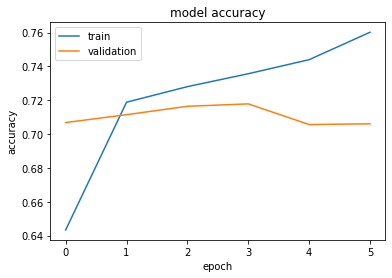

In [44]:
print(history.history.keys())
#summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [45]:
model1.evaluate(padded_test,y_test)

630/630 [==============================] - 7s 11ms/step - loss: 0.8105 - accuracy: 0.7046


[0.8105441331863403, 0.704609751701355]

In [46]:
y_pred=np.argmax(model1.predict(padded_test), axis=-1)

In [47]:
print(metrics.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.76      0.75      0.75      6717
           1       0.61      0.55      0.58      6718
           2       0.73      0.82      0.77      6718

    accuracy                           0.70     20153
   macro avg       0.70      0.70      0.70     20153
weighted avg       0.70      0.70      0.70     20153



### Predicitng a single review

In [48]:
string="This product is different. I have ordered this product before and I know that pure oil's colour is yellow instead of orange."

str_clean=(text_cleanup(string))

print("Text after initial clean up:\n ",(str_clean))
str_clean=text_to_word_sequence(str_clean)
encoded_test_str=t.texts_to_sequences(str_clean)
encoded_test_str=np.array(encoded_test_str)
encoded_test_str=encoded_test_str.reshape(1,11)
padded_test_str=pad_sequences(encoded_test_str, padding='post', maxlen=padded_train.shape[1])

Text after initial clean up:
  product different order product know pure oil colour yellow instead orange


In [49]:
print("Shape of final processed data: ", padded_test_str.shape)

Shape of final processed data:  (1, 510)


In [50]:
# Predicting probabilities of all classes from a few input images 
y_prob = model1.predict(padded_test_str)
y_prob.round(2)

# This review is classified as 1, i.e. Good

array([[0.27, 0.26, 0.47]], dtype=float32)

In [52]:
from keras import backend as K
K.clear_session()

#### Using CNN

In [53]:
model2 = Sequential([
  Embedding(input_dim=50001, output_dim=16,input_length=padded_train.shape[1]),
  Dropout(0.5),
    Conv1D(filters=32, kernel_size=3, strides=1, padding="valid", activation='relu'),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=16, kernel_size=3, strides=1, padding="valid", activation='relu'),
    MaxPooling1D(), 
    Flatten(),
  Dense(32, activation='relu'),
  Dropout(0.5),
  Dense(3, activation='softmax')
])

In [54]:
model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 510, 16)           800016    
_________________________________________________________________
dropout (Dropout)            (None, 510, 16)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 508, 32)           1568      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 254, 32)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 252, 16)           1552      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 126, 16)           0         
_________________________________________________________________
flatten (Flatten)            (None, 2016)              0

In [55]:
model2.compile(optimizer='adam',
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

In [56]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(patience=3)


result=model2.fit(padded_train, y_train, epochs=8, batch_size=128, validation_data=(padded_val, y_val), callbacks=[early_stopping])

Epoch 1/8
504/504 [==============================] - 79s 157ms/step - loss: 0.8971 - accuracy: 0.5561 - val_loss: 0.7017 - val_accuracy: 0.6773
Epoch 2/8
504/504 [==============================] - 87s 172ms/step - loss: 0.7054 - accuracy: 0.6825 - val_loss: 0.6945 - val_accuracy: 0.6742
Epoch 3/8
504/504 [==============================] - 89s 177ms/step - loss: 0.6567 - accuracy: 0.7101 - val_loss: 0.6877 - val_accuracy: 0.6811
Epoch 4/8
504/504 [==============================] - 86s 171ms/step - loss: 0.6237 - accuracy: 0.7266 - val_loss: 0.6757 - val_accuracy: 0.6867
Epoch 5/8
504/504 [==============================] - 87s 172ms/step - loss: 0.5933 - accuracy: 0.7435 - val_loss: 0.7255 - val_accuracy: 0.6721
Epoch 6/8
504/504 [==============================] - 84s 167ms/step - loss: 0.5701 - accuracy: 0.7553 - val_loss: 0.7141 - val_accuracy: 0.6836
Epoch 7/8
504/504 [==============================] - 74s 146ms/step - loss: 0.5423 - accuracy: 0.7727 - val_loss: 0.6916 - val_accuracy:

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


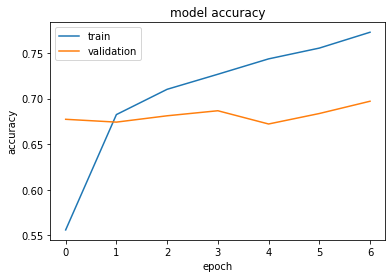

In [57]:
print(result.history.keys())
#summarize history for accuracy
plt.plot(result.history['accuracy'])
plt.plot(result.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [59]:
model2.evaluate(padded_test,y_test)

630/630 [==============================] - 6s 9ms/step - loss: 0.7028 - accuracy: 0.6962


[0.7027720212936401, 0.6961742639541626]

In [61]:
y_pred2=np.argmax(model2.predict(padded_test), axis=-1)

In [62]:
print(metrics.classification_report(y_test,y_pred2))

              precision    recall  f1-score   support

           0       0.81      0.65      0.72      6717
           1       0.56      0.63      0.59      6718
           2       0.76      0.81      0.78      6718

    accuracy                           0.70     20153
   macro avg       0.71      0.70      0.70     20153
weighted avg       0.71      0.70      0.70     20153



### Conclusion

Text Classification using Keras Embedding - with CNN and with Dense NN gives approx same accuracy, precision and recall. 